In [2]:
import pandas as pd
import numpy as np
import datetime as dt

from spacepy import coordinates as coord
from spacepy.time import Ticktock

In [3]:
base_f_loc = '/storage/silver/stfc_cg/hf832176/data/THEMIS/'

# <center> Read in Data </center>

In [4]:
!ls {base_f_loc}*.pkl

/storage/silver/stfc_cg/hf832176/data/THEMIS/tha_esa_energy_levels.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/tha_mag.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/tha.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/tha_sst_energy_levels.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/thb_mag.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/thb.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/thc_mag.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/thc.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/thd_mag.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/thd.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/the_mag.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/the.pkl


In [ ]:
dawn_f2 = pd.read_pickle(base_f_loc+'dawn_f2')
dawn_f2 = pd.read_pickle(base_f_loc+'dusk_f2')

In [5]:
e_levs_sst = pd.read_pickle(base_f_loc+'tha_sst_energy_levels.pkl')
# display(e_levs_sst.T)
e_levs_esa = pd.read_pickle(base_f_loc+'tha_esa_energy_levels.pkl')
# display(e_levs_esa.T)

e_levs = [i for i in e_levs_esa.index[::-1]]+[i for i in e_levs_sst.index]
# display(e_levs)

,31000.0,41000.0,52000.0,65500.0,93000.0,139000.0,203500.0,293000.0,408000.0,561500.0,719500.0,NaN,NaN,NaN,NaN,NaN
eV,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15


,31766.636719,26831.396484,20383.251953,15484.854492,11763.428711,8936.366211,6788.923828,5157.255371,3917.749512,2976.849854,...,83.861748,63.502251,48.474998,36.841000,28.115499,20.844250,15.996750,12.603500,9.210250,7.271250
eV,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31


In [16]:
e_levs2 = e_levs.copy()
e_levs2 = e_levs2[:31] + e_levs2[32:-5]

In [17]:
dawn_f3 = dawn_f2.copy()
# Replacing 0 with np.nan in relevant columns
dawn_f3[dawn_f3.loc[:,dawn_f3.columns[71:]] == 0] = np.nan
# Dropping nans in relevant columns
dawn_f3 = dawn_f3.dropna(subset=dawn_f2.columns[71:])

dusk_f3 = dusk_f2.copy()
# Replacing 0 with np.nan in relevant columns
dusk_f3[dusk_f3.loc[:,dusk_f3.columns[71:]] == 0] = np.nan
# Dropping nans in relevant columns
dusk_f3 = dusk_f3.dropna(subset=dusk_f2.columns[71:])

In [18]:
nfloc = '/storage/silver/stfc_cg/shared/themis_lstar/'

#######

da_lcds = pd.read_csv(nfloc+'for_teo.csv')

da_lcds.index = [dt.datetime.strptime(i, '%d/%m/%Y %H:%M')
                 for i in da_lcds.time]
da_lcds = da_lcds.drop(['time','0','mlt'],axis=1)

da_lcds['counts'] = da_lcds.isnull().sum(axis=1).tolist()
da_lcds['in_out'] = [False if i >= 5 else True
                     for i in da_lcds.counts]

#######

du_lcds = pd.read_csv(nfloc+'for_teo_dusk.csv')

du_lcds.index = [dt.datetime.strptime(i, '%d/%m/%Y %H:%M')
                 for i in du_lcds['Unnamed: 0']]
du_lcds = du_lcds.drop(['Unnamed: 0','0','mlt'],axis=1)

du_lcds['counts'] = du_lcds.isnull().sum(axis=1).tolist()
du_lcds['in_out'] = [False if i >= 5 else True
                     for i in du_lcds.counts]

In [19]:
dawn_f3['in_ms'] = da_lcds['in_out']
dusk_f3['in_ms'] = du_lcds['in_out']

In [20]:
cats = np.histogram(dawn_f3.r,bins=20,range=(5,15))
dogs = np.histogram(dusk_f3.r,bins=20,range=(5,15))

minsamp = np.min([cats[0],dogs[0]])
print(minsamp)

65


In [21]:
def r_sampling(dawn_data,dusk_data,radial_bins):
    
    cats = np.histogram(dawn_data.r,bins=radial_bins,range=(5,15))
    dogs = np.histogram(dusk_data.r,bins=radial_bins,range=(5,15))
    minsamp = np.min([cats[0],dogs[0]])
    
    dawn_ss,dusk_ss = [],[]
    for i,j in zip(cats[1][:-1],cats[1][1:]):
        dawn_ss.append(dawn_data[(dawn_data.r > i) &
                                (dawn_data.r < j)]
                        .sample(n=minsamp))
        dusk_ss.append(dusk_data[(dusk_data.r > i) &
                                (dusk_data.r < j)]
                        .sample(n=minsamp))

    dawn_f4 = pd.concat(dawn_ss)
    dusk_f4 = pd.concat(dusk_ss)
    
    return(dawn_f4,dusk_f4)

# <center> Plotting Data </center>

In [22]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import seaborn as sbn
from matplotlib.gridspec import GridSpec as gridspec

In [27]:
nins,nouts = [],[]
for i in range(100):
    dawn_f4,dusk_f4 = r_sampling(dawn_f3,dusk_f3,20)
    
    nin1,_ = np.histogram(dawn_f4[dawn_f4.in_ms==True]['pos_r_mag'],bins=50,range=(5,15))
    nout1,_ = np.histogram(dawn_f4[dawn_f4.in_ms==False]['pos_r_mag'],bins=50,range=(5,15))
    
    nin2,_ = np.histogram(dusk_f4[dusk_f4.in_ms==True]['pos_r_mag'],bins=50,range=(5,15))
    nout2,_ = np.histogram(dusk_f4[dusk_f4.in_ms==False]['pos_r_mag'],bins=50,range=(5,15))
    
    nins.append(nin1)
    nins.append(nin2)
    nouts.append(nout1)
    nouts.append(nout2)

nins=np.array(nins)
nouts=np.array(nouts)

In [28]:
ninsum = nins.sum(axis=0)
noutsum = nouts.sum(axis=0)
sumsum = ninsum+noutsum

In [ ]:
# # Plotting distributions of the radial distance.
# fig = plt.figure(figsize=(8,4.5),dpi=500)
# ax1 = plt.subplot(111)

# n,bins = np.histogram(dawn_f4['pos_r_mag'],bins=50,range=(5,15))

# ax1.hist(bins[:-1],bins,weights=ninsum/sumsum,
#          histtype='step',label='L* Defined')
# # ax1.hist(bins[:-1],bins,weights=noutsum/sumsum,
# #          histtype='step',label='L* Undefined')

# plt.grid(axis='y')
# ax1.legend(loc=(0.1,0.2),frameon=False)
# ax1.set_ylabel('Occurance Fraction')
# ax1.set_xlabel('Radial Distance, R$_E$')

# sbn.despine()

# # path = '/home/users/hf832176/My Documents/Coding/themis/Graphs/write_up/'
# # plt.savefig(fname = path+'lstar_r_dist.pdf',format='pdf',bbox_inches='tight')
# # # plt.savefig(fname = path+'lstar_r_dist.eps',format='eps',bbox_inches='tight')
# # plt.savefig(fname = path+'lstar_r_dist.png',format='png',bbox_inches='tight')

# plt.show()
# # plt.close(fig)

In [ ]:
EvR_da.columns

In [29]:
da_f4,du_f4 = [],[]
for i in range(100):
    dawn_f4,dusk_f4 = r_sampling(dawn_f3,dusk_f3,20)
    da_f4.append(dawn_f4)
    du_f4.append(dusk_f4)
    
dawn_f5 = pd.concat(da_f4,ignore_index=True)
dusk_f5 = pd.concat(du_f4,ignore_index=True)

In [ ]:
# # Plotting boxplots of log10(DEF) for all energies.
# plt.figure(figsize=(12,4.5*1.5),dpi=500)
# axs = [plt.subplot(2,2,i+1) for i in range(4)]

# dawn_args = {'widths':0.35,'sym':'','whis':[5,95],
#              'medianprops':dict(linewidth=0),
#              'boxprops':dict(color='C0'),
#              'whiskerprops':dict(color='C0'),
#              'capprops':dict(color='C0')}

# dusk_args = {'widths':0.35,'sym':'','whis':[5,95],
#              'medianprops':dict(linewidth=0),
#              'boxprops':dict(color='C1'),
#              'whiskerprops':dict(color='C1'),
#              'capprops':dict(color='C1')}

# #######

# axs[0].boxplot(dawn_f5[dawn_f5.in_ms==True].iloc[:,71:-1].values,
#                **dawn_args)

# axs[0].plot(np.arange(1,43,1),dawn_f5[dawn_f5.in_ms==True].iloc[:,71:-1].median(),
#             c='C0',linewidth=2)
# axs[0].plot(np.arange(1,43,1),dusk_f5[dusk_f5.in_ms==True].iloc[:,71:-1].median(),
#             c='C1',linestyle='-',linewidth=2)

# axs[0].set_title('L* Defined')

# axs[0].set_ylabel('Log$_{10}$(PSD)')

# #######

# axs[1].boxplot(dawn_f5[dawn_f5.in_ms==False].iloc[:,71:-1].values,
#                **dawn_args)

# axs[1].plot(np.arange(1,43,1),dawn_f5[dawn_f5.in_ms==False].iloc[:,71:-1].median(),
#             c='C0',linewidth=2,label='Dawn')
# axs[1].plot(np.arange(1,43,1),dusk_f5[dusk_f5.in_ms==False].iloc[:,71:-1].median(),
#             c='C1',linewidth=2,label='Dusk')

# axs[1].set_title('L* Undefined')
# axs[1].legend(loc='lower left',frameon=False)

# #######

# axs[2].boxplot(dusk_f5[dusk_f5.in_ms==True].iloc[:,71:-1].values,
#                **dusk_args)

# axs[2].plot(np.arange(1,43,1),dawn_f5[dawn_f5.in_ms==True].iloc[:,71:-1].median(),
#             c='C0',linewidth=2)
# axs[2].plot(np.arange(1,43,1),dusk_f5[dusk_f5.in_ms==True].iloc[:,71:-1].median(),
#             c='C1',linewidth=2)

# axs[2].set_ylabel('Log$_{10}$(PSD)')
# axs[2].set_xlabel('Log$_{10}$(Energy, eV)')

# #######

# axs[3].boxplot(dusk_f5[dusk_f5.in_ms==False].iloc[:,71:-1].values,
#               **dusk_args)

# axs[3].plot(np.arange(1,43,1),dawn_f5[dawn_f5.in_ms==False].iloc[:,71:-1].median(),
#             c='C0',linewidth=2)
# axs[3].plot(np.arange(1,43,1),dusk_f5[dusk_f5.in_ms==False].iloc[:,71:-1].median(),
#             c='C1',linewidth=2)

# axs[3].set_xlabel('Log$_{10}$(Energy, eV)')

# #######

# [i.fill_between([-10,50],[1e+47]*2,[1e+64]*2,color='C7',alpha=0.5) for i in axs]
# [i.grid(axis='y',alpha=0.5,color='k') for i in axs]

# [i.set_xticks(np.arange(1,43,3)) for i in axs]
# [i.set_xlim(0,43) for i in axs]
# [i.set_xticklabels(["{0:.2f}".format(i) for i in np.log10(e_levs2[::3])]) for i in axs]
# [i.set_ylim(1e+48,1e+63) for i in axs]
# [i.set_yscale('log') for i in axs]

# plt.tight_layout()
# sbn.despine()

# # path = '/home/users/hf832176/My Documents/Coding/themis/Graphs/write_up/'
# # plt.savefig(fname = path+'PSDvE_inout_box.pdf',format='pdf',bbox_inches='tight')
# # # plt.savefig(fname = path+'PSDvE_dd_avg.eps',format='eps',bbox_inches='tight')
# # plt.savefig(fname = path+'PSDvE_inout_box.png',format='png',bbox_inches='tight')

# plt.show()

In [31]:
# Custom widths for boxplots on log scale
initwidth = 0.06
wlims = np.array([[i-initwidth/2,i+initwidth/2] for i in np.log10(e_levs2)])
wlimlog = 10**wlims
logwidths = wlimlog[:,1]-wlimlog[:,0]
# logwidths

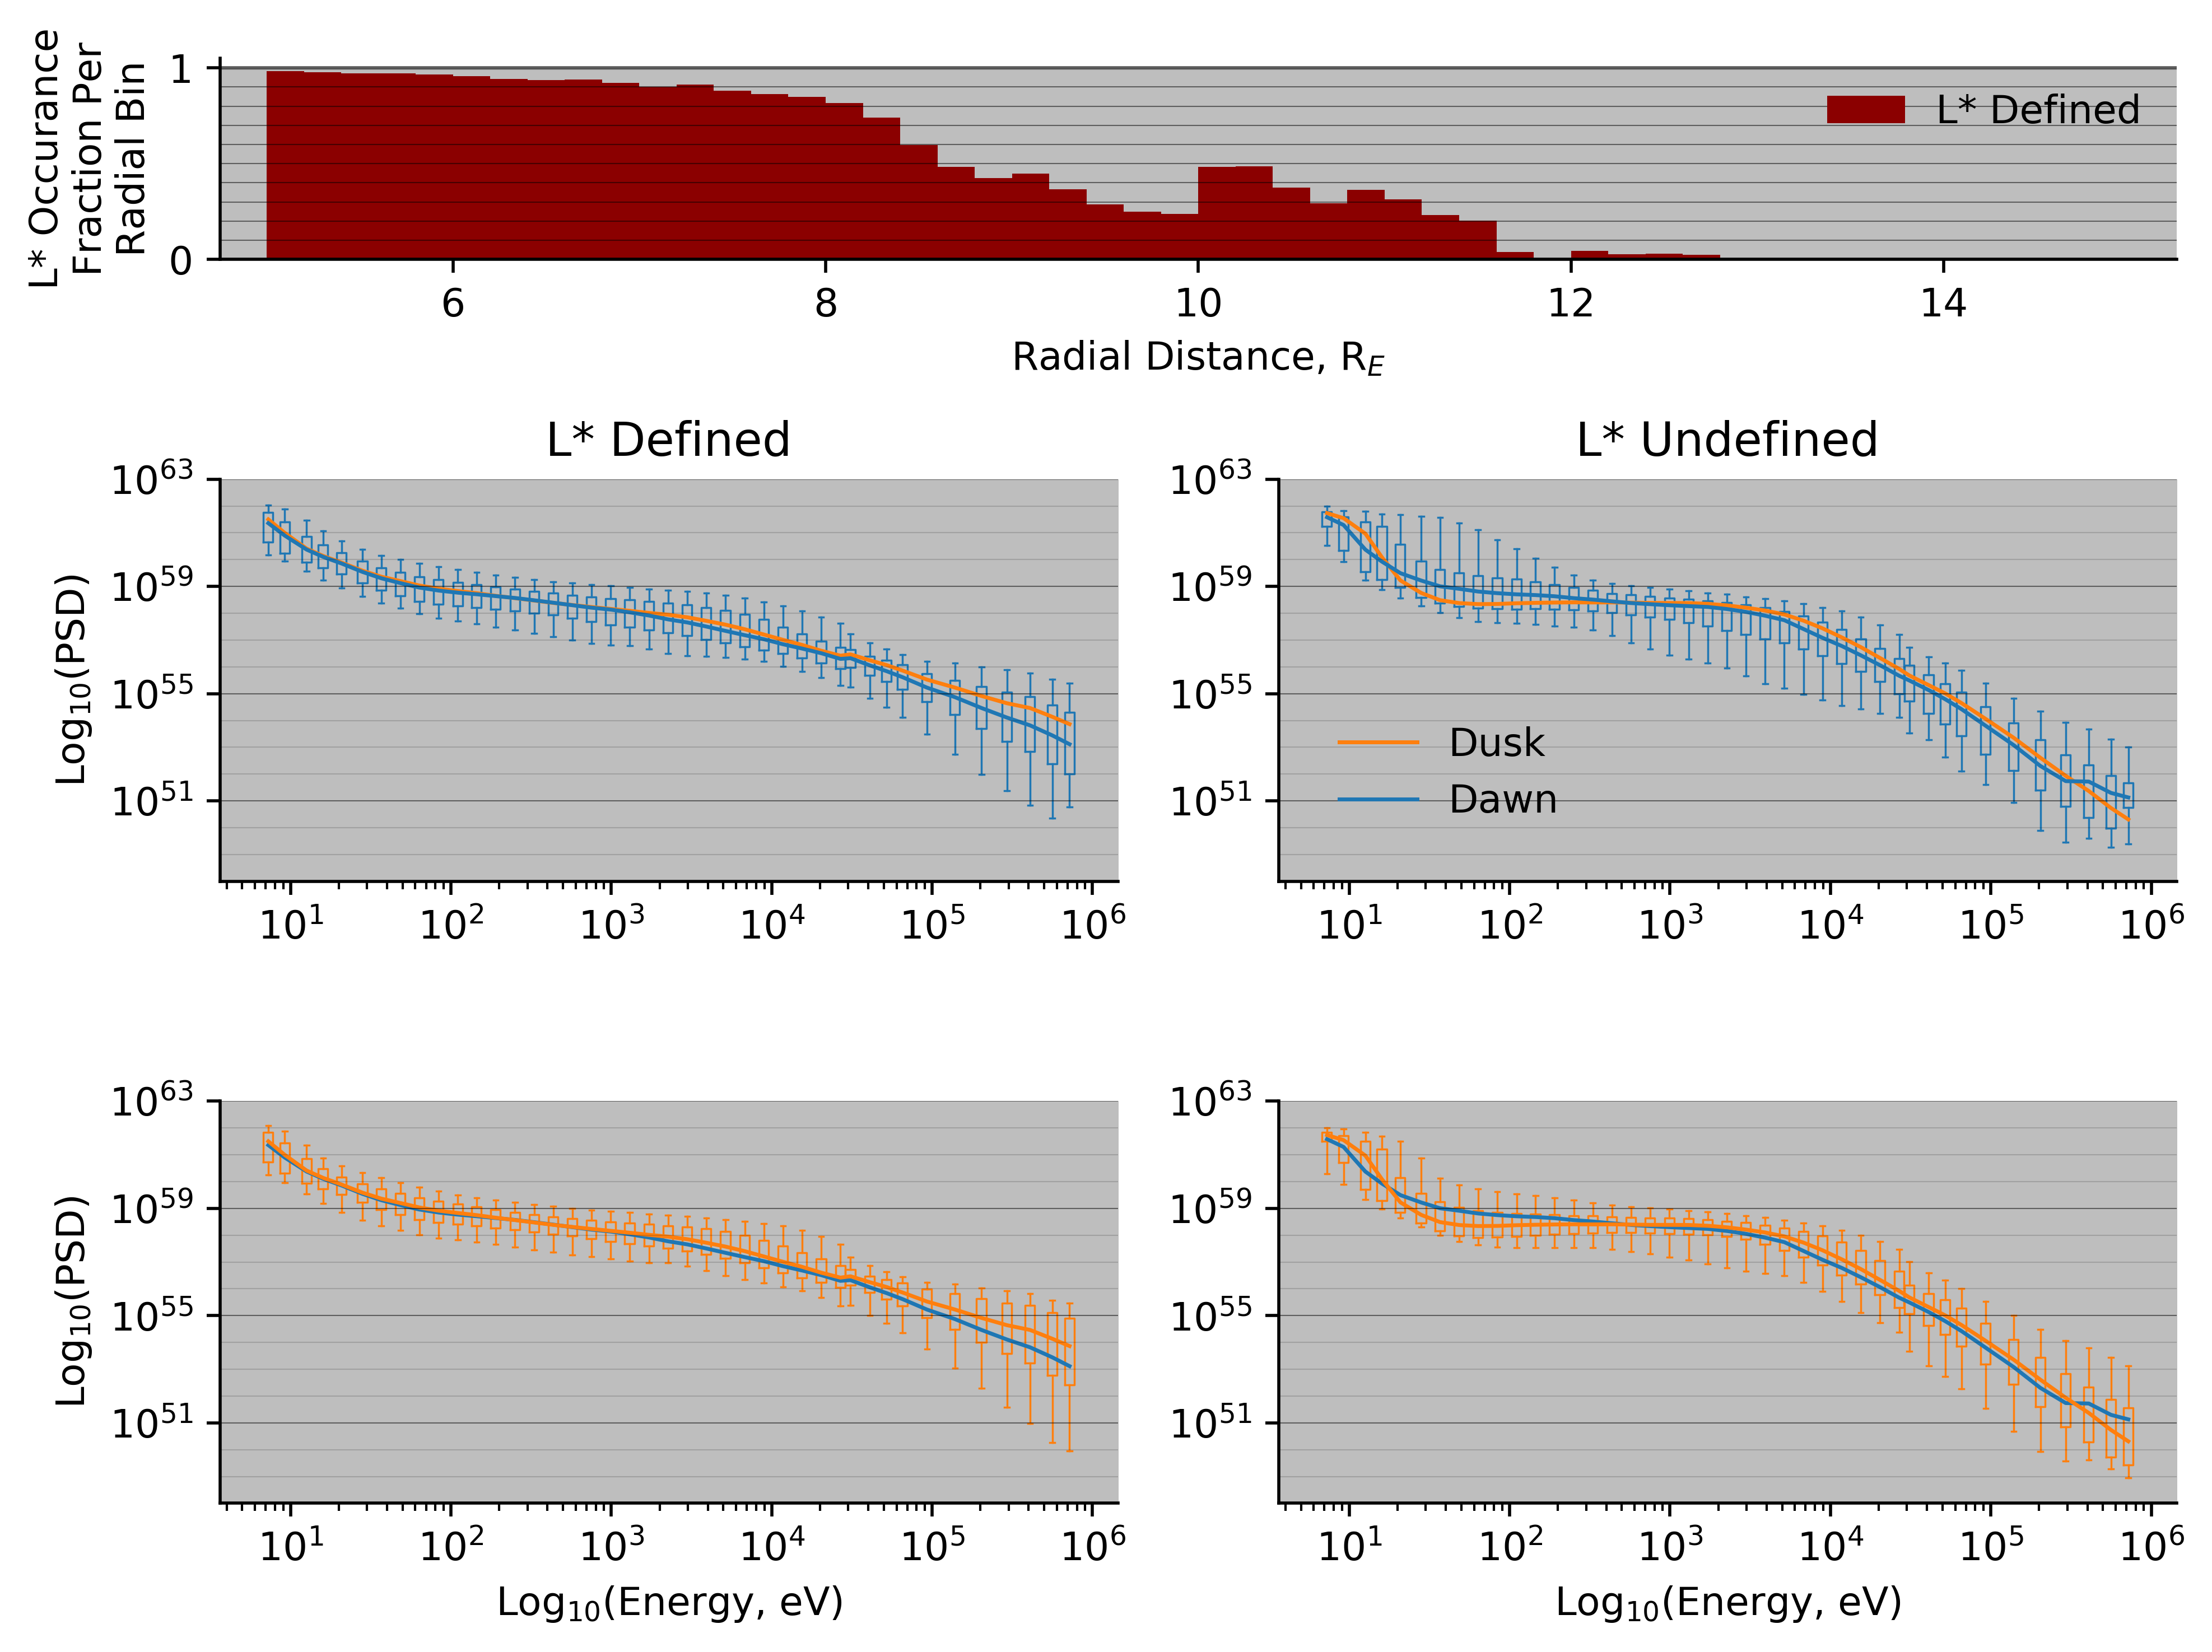

In [34]:
# Plotting boxplots of log10(DEF) for all energies.
fig = plt.figure(figsize=(8,6),dpi=500,tight_layout=True)
gs = gridspec(3,2,height_ratios=(0.5,1,1))

#######

ax1 = fig.add_subplot(gs[0,:])

n,bins = np.histogram(dawn_f4['pos_r_mag'],bins=50,range=(5,15))

ax1.hist(bins[:-1],bins,weights=ninsum/sumsum,
         histtype='stepfilled',label='L* Defined',color='darkred')
# ax1.hist(bins[:-1],bins,weights=noutsum/sumsum,
#          histtype='step',label='L* Undefined')

ax1.grid(axis='y',color='k',alpha=0.5)
ax1.legend(loc='upper right',frameon=False)
ax1.set_ylabel('L* Occurance\nFraction Per\nRadial Bin')
ax1.set_xlabel('Radial Distance, R$_E$')

#######

axs = [fig.add_subplot(gs[i,j]) for i in range(1,3) for j in range(2)]

dawn_args = {'widths':logwidths,'sym':'','whis':[5,95],
             'positions':e_levs2,
             'medianprops':dict(linewidth=0),
             'boxprops':dict(color='C0',linewidth=0.5),
             'whiskerprops':dict(color='C0',linewidth=0.5),
             'capprops':dict(color='C0',linewidth=0.5)}

dusk_args = {'widths':logwidths,'sym':'','whis':[5,95],
             'positions':e_levs2,
             'medianprops':dict(linewidth=0),
             'boxprops':dict(color='C1',linewidth=0.5),
             'whiskerprops':dict(color='C1',linewidth=0.5),
             'capprops':dict(color='C1',linewidth=0.5)}

#######

axs[0].boxplot(dawn_f5[dawn_f5.in_ms==True].iloc[:,71:-1].values,
               **dawn_args)

axs[0].plot(e_levs2,dusk_f5[dusk_f5.in_ms==True].iloc[:,71:-1].median(),
            c='C1',linewidth=1)
axs[0].plot(e_levs2,dawn_f5[dawn_f5.in_ms==True].iloc[:,71:-1].median(),
            c='C0',linewidth=1)

axs[0].set_title('L* Defined')

axs[0].set_ylabel('Log$_{10}$(PSD)')

#######

axs[1].boxplot(dawn_f5[dawn_f5.in_ms==False].iloc[:,71:-1].values,
               **dawn_args)

axs[1].plot(e_levs2,dusk_f5[dusk_f5.in_ms==False].iloc[:,71:-1].median(),
            c='C1',linewidth=1,label='Dusk')
axs[1].plot(e_levs2,dawn_f5[dawn_f5.in_ms==False].iloc[:,71:-1].median(),
            c='C0',linewidth=1,label='Dawn')

axs[1].set_title('L* Undefined')
axs[1].legend(loc=(0.05,0.1125),frameon=False)

#######

axs[2].boxplot(dusk_f5[dusk_f5.in_ms==True].iloc[:,71:-1].values,
               **dusk_args)

axs[2].plot(e_levs2,dawn_f5[dawn_f5.in_ms==True].iloc[:,71:-1].median(),
            c='C0',linewidth=1)
axs[2].plot(e_levs2,dusk_f5[dusk_f5.in_ms==True].iloc[:,71:-1].median(),
            c='C1',linewidth=1)

axs[2].set_ylabel('Log$_{10}$(PSD)')
axs[2].set_xlabel('Log$_{10}$(Energy, eV)')

#######

axs[3].boxplot(dusk_f5[dusk_f5.in_ms==False].iloc[:,71:-1].values,
              **dusk_args)

axs[3].plot(e_levs2,dawn_f5[dawn_f5.in_ms==False].iloc[:,71:-1].median(),
            c='C0',linewidth=1)
axs[3].plot(e_levs2,dusk_f5[dusk_f5.in_ms==False].iloc[:,71:-1].median(),
            c='C1',linewidth=1)

axs[3].set_xlabel('Log$_{10}$(Energy, eV)')

#######

[i.fill_between([min(e_levs2)/5,max(e_levs)*5],
                [1e+47]*2,[1e+64]*2,
                color='C7',alpha=0.5) for i in axs]
ax1.fill_between([4,16],[0]*2,[1]*2,color='C7',alpha=0.5)
# [i.grid(axis='y',alpha=0.5,color='k') for i in axs]

# Adding Gridlines to the y-axis
[ax1.plot([4.75,15.25],[i,i],alpha=0.5,c='k',linewidth=0.3)
 for i in np.arange(0,1,0.1)]

majt = np.arange(51,64,4)
mint = np.arange(48,64,1)
alphas = [0.5 if i in majt else 0.15 for i in mint]

[i.plot([min(e_levs2)/2,max(e_levs2)*2],[1e+48*10**j,1e+48*10**j],
        c='k',alpha=k,linewidth=0.3)
 for i in axs for j,k in zip(np.arange(0,16,1),alphas)]

# [i.set_xticks(np.arange(1,43,4)) for i in axs]
[i.set_xlim(min(e_levs2)/2,max(e_levs2)*2) for i in axs]
ax1.set_xlim(4.75,15.25)
# [i.set_xticklabels(["{0:.2f}".format(i) for i in np.log10(e_levs2[::4])]) for i in axs]
[i.set_ylim(1e+48,1e+63) for i in axs]
[i.set_yscale('log') for i in axs]
[i.set_xscale('log') for i in axs]

# plt.tight_layout()
sbn.despine()

path = '/home/users/hf832176/My Documents/Coding/themis/Graphs/write_up/'
plt.savefig(fname = path+'lstarplot.pdf',format='pdf',bbox_inches='tight')
# plt.savefig(fname = path+'PSDvE_dd_avg.eps',format='eps',bbox_inches='tight')
plt.savefig(fname = path+'lstarplot.png',format='png',bbox_inches='tight')

plt.show()

# <center> Kolmogorov-Smirnov Statistic </center>

In [108]:
from scipy.stats import ks_2samp as kss

In [109]:
# Critical KS stat at the p={0.05,0.001} level
ks_crit5 = 1.36*np.sqrt(2*len(dawn_f5)/(len(dawn_f5)**2))
ks_crit01 = 1.95*np.sqrt(2*len(dawn_f5)/(len(dawn_f5)**2))
print(ks_crit5,ks_crit01)

# If stat > critical value then distributions are different.

0.005334358875758605 0.007648529270389177


In [110]:
ks_df = pd.DataFrame(index = [i for i in dawn_f5.columns[71:-1]],
                     columns=['stat','p-val'])

ks_df['stat'] = [kss(dawn_f5[dawn_f5.in_ms==True][i],
                     dawn_f5[dawn_f5.in_ms==False][i])[0]
                 for i in dawn_f5.columns[71:-1]]
ks_df['p-val'] = [kss(dawn_f5[dawn_f5.in_ms==True][i],
                      dawn_f5[dawn_f5.in_ms==False][i])[1]
                  for i in dawn_f5.columns[71:-1]]
ks_df['p-val'] = ['<1e-10' if i < 1e-10 else i for i in ks_df['p-val']]
ks_df.describe()

,stat
count,42.000000
mean,0.273594
std,0.193351
min,0.045159
25%,0.121402
50%,0.195966
75%,0.451059
max,0.629487


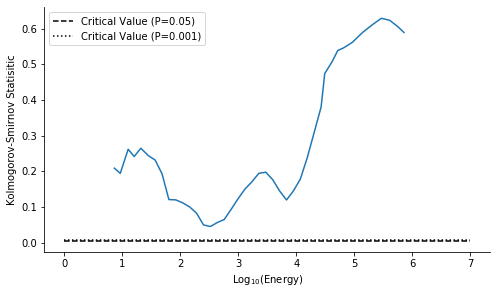

In [111]:
plt.figure(figsize=(8,4.5))
plt.plot([np.log10(i) for i in e_levs2],ks_df.stat)
plt.plot([0,7],[ks_crit5,ks_crit5],'k--',label='Critical Value (P=0.05)')
plt.plot([0,7],[ks_crit01,ks_crit01],'k:',label='Critical Value (P=0.001)')

plt.ylabel('Kolmogorov-Smirnov Statisitic')
plt.xlabel('Log$_{10}$(Energy)')
plt.legend()
sbn.despine()
plt.show()

# <center> Anderson-Darlin Test </center>

In [112]:
from scipy.stats import anderson_ksamp as adt

In [113]:
# AD stat critical values for
# P={0.25,0.10,0.05,0.025,0.01,0.005,0.001}

AD_crit = adt([dusk_f5[dusk_f5.in_ms==True].iloc[:,71],
               dusk_f5[dusk_f5.in_ms==False].iloc[:,71]])[1]

# If AD stat > crit value, different dists

<ipython-input-113-c9e2a8909160>:4: UserWarning: p-value floored: true value smaller than 0.001
  AD_crit = adt([dusk_f5[dusk_f5.in_ms==True].iloc[:,71],


In [128]:
# ad_df = pd.DataFrame(index = [i for i in dusk_f2.columns[70:]],
#                      columns=['stat','p-val'])

# ad_df['stat'] = [adt([dawn_f2[i],dusk_f2[i]])[0] for i in dusk_f2.columns[70:]]
# # ad_df['crit val'] = [adt([dawn[i],dusk[i]])[1] for i in dusk.columns[0:11]]
# ad_df['p-val'] = [adt([dawn_f2[i],dusk_f2[i]])[2] for i in dusk_f2.columns[70:]]
# ad_df['p-val'] = ['<1e-10' if i < 1e-10 else i for i in ad_df['p-val']]
# # ad_df

In [114]:
ad_df = pd.DataFrame(index = [i for i in dawn_f5.columns[71:-1]],
                     columns=['stat','p-val'])

ad_df['stat'] = [adt([dawn_f5[dawn_f5.in_ms==True][i],
                     dawn_f5[dawn_f5.in_ms==False][i]])[0]
                 for i in dawn_f5.columns[71:-1]]
ad_df['p-val'] = [adt([dawn_f5[dawn_f5.in_ms==True][i],
                      dawn_f5[dawn_f5.in_ms==False][i]])[2]
                  for i in dawn_f5.columns[71:-1]]
ad_df['p-val'] = ['<1e-10' if i < 1e-10 else i for i in ad_df['p-val']]
ad_df.describe()

<ipython-input-114-f3722f7e02b7>:4: UserWarning: p-value floored: true value smaller than 0.001
  ad_df['stat'] = [adt([dawn_f5[dawn_f5.in_ms==True][i],
<ipython-input-114-f3722f7e02b7>:7: UserWarning: p-value floored: true value smaller than 0.001
  ad_df['p-val'] = [adt([dawn_f5[dawn_f5.in_ms==True][i],


,stat,p-val
count,42.000000,42.000
mean,10536.016716,0.001
std,13136.326544,0.000
min,151.145953,0.001
25%,1566.396824,0.001
50%,3345.159218,0.001
75%,20259.471957,0.001
max,36742.535156,0.001


In [115]:
AD_crit

array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546])

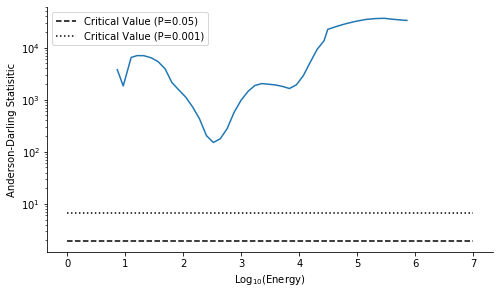

In [117]:
plt.figure(figsize=(8,4.5))
plt.plot([np.log10(i) for i in e_levs2],ad_df.stat)
plt.plot([0,7],[AD_crit[2],AD_crit[2]],'k--',label='Critical Value (P=0.05)')
plt.plot([0,7],[AD_crit[-1],AD_crit[-1]],'k:',label='Critical Value (P=0.001)')

plt.ylabel('Anderson-Darling Statisitic')
plt.xlabel('Log$_{10}$(Energy)')
plt.yscale('log')
plt.legend()
sbn.despine()
plt.show()

# <center> How Many B-Field Models? </center>

In [138]:
display(da_lcds.describe())
display(du_lcds.describe())

,T89,OPQUIET,T96,OSTA,T01STORM,T05,counts
count,18528.000000,19530.000000,10881.000000,10382.000000,10852.000000,10451.000000,22751.000000
mean,6.530875,6.554410,6.582648,6.619871,6.762917,6.512507,2.456244
std,1.088267,1.127925,1.119389,1.138086,1.151979,1.095145,2.313878
min,4.431754,4.682661,4.352881,4.555142,4.588935,4.493635,0.000000
25%,5.642553,5.649333,5.662845,5.691452,5.804999,5.599296,0.000000
50%,6.395922,6.389779,6.448514,6.461096,6.658935,6.397323,4.000000
75%,7.301464,7.274203,7.402492,7.422249,7.623095,7.298247,4.000000
max,9.713323,9.866786,9.753539,10.233928,10.268541,10.322313,6.000000


,T89,OPQUIET,T96,OSTA,T01STORM,T05,counts
count,11389.000000,12367.000000,5632.000000,5833.000000,3885.000000,3638.000000,34328.000000
mean,7.460630,7.510034,7.307218,7.483396,7.088412,6.894768,4.754836
std,1.468743,1.422274,1.378740,1.454306,1.466948,1.473084,1.858143
min,4.465755,4.607026,4.324893,4.515027,4.499320,4.445193,0.000000
25%,6.155569,6.260106,6.059398,6.221312,5.686827,5.480506,4.000000
50%,7.826441,8.002429,7.675158,7.838200,7.148101,6.839802,6.000000
75%,8.835227,8.664781,8.410791,8.598194,8.404716,8.338082,6.000000
max,9.643260,9.757365,10.079522,18.877817,9.935725,10.534068,6.000000


In [147]:
# for j in range(1,7):
#     da_lcds['counts'] = da_lcds.isnull().sum(axis=1).tolist()
#     da_lcds['in_out'] = [False if i >= j else True
#                          for i in da_lcds.counts]
#     du_lcds['counts'] = du_lcds.isnull().sum(axis=1).tolist()
#     du_lcds['in_out'] = [False if i >= j else True
#                          for i in du_lcds.counts]
    
#     dawn_f3['in_ms'] = da_lcds['in_out']
#     dusk_f3['in_ms'] = du_lcds['in_out']
    
#     # Plotting distributions of the radial distance.
#     fig = plt.figure(figsize=(4,2.25),dpi=500)
#     ax1 = plt.subplot(111)

#     n,bins = np.histogram(dawn_f3['pos_r_mag'],bins=100,range=(5,15))
#     nin,binin = np.histogram(dawn_f3[dawn_f3.in_ms==True]['pos_r_mag'],bins=100,range=(5,15))
#     nou,binou = np.histogram(dawn_f3[dawn_f3.in_ms==False]['pos_r_mag'],bins=100,range=(5,15))

#     ax1.hist(bins[:-1],bins,weights=nin/n,
#              histtype='step',label='Inside')
#     ax1.hist(bins[:-1],bins,weights=nou/n,
#              histtype='step',label='Outside')

#     ax1.set_title('Models without L*:'+str(j))
#     ax1.legend(loc='upper left',frameon=False)
#     ax1.set_ylabel('Occurance Fraction')
#     ax1.set_xlabel('Radial Distance, R$_E$')

#     sbn.despine()

#     plt.show()

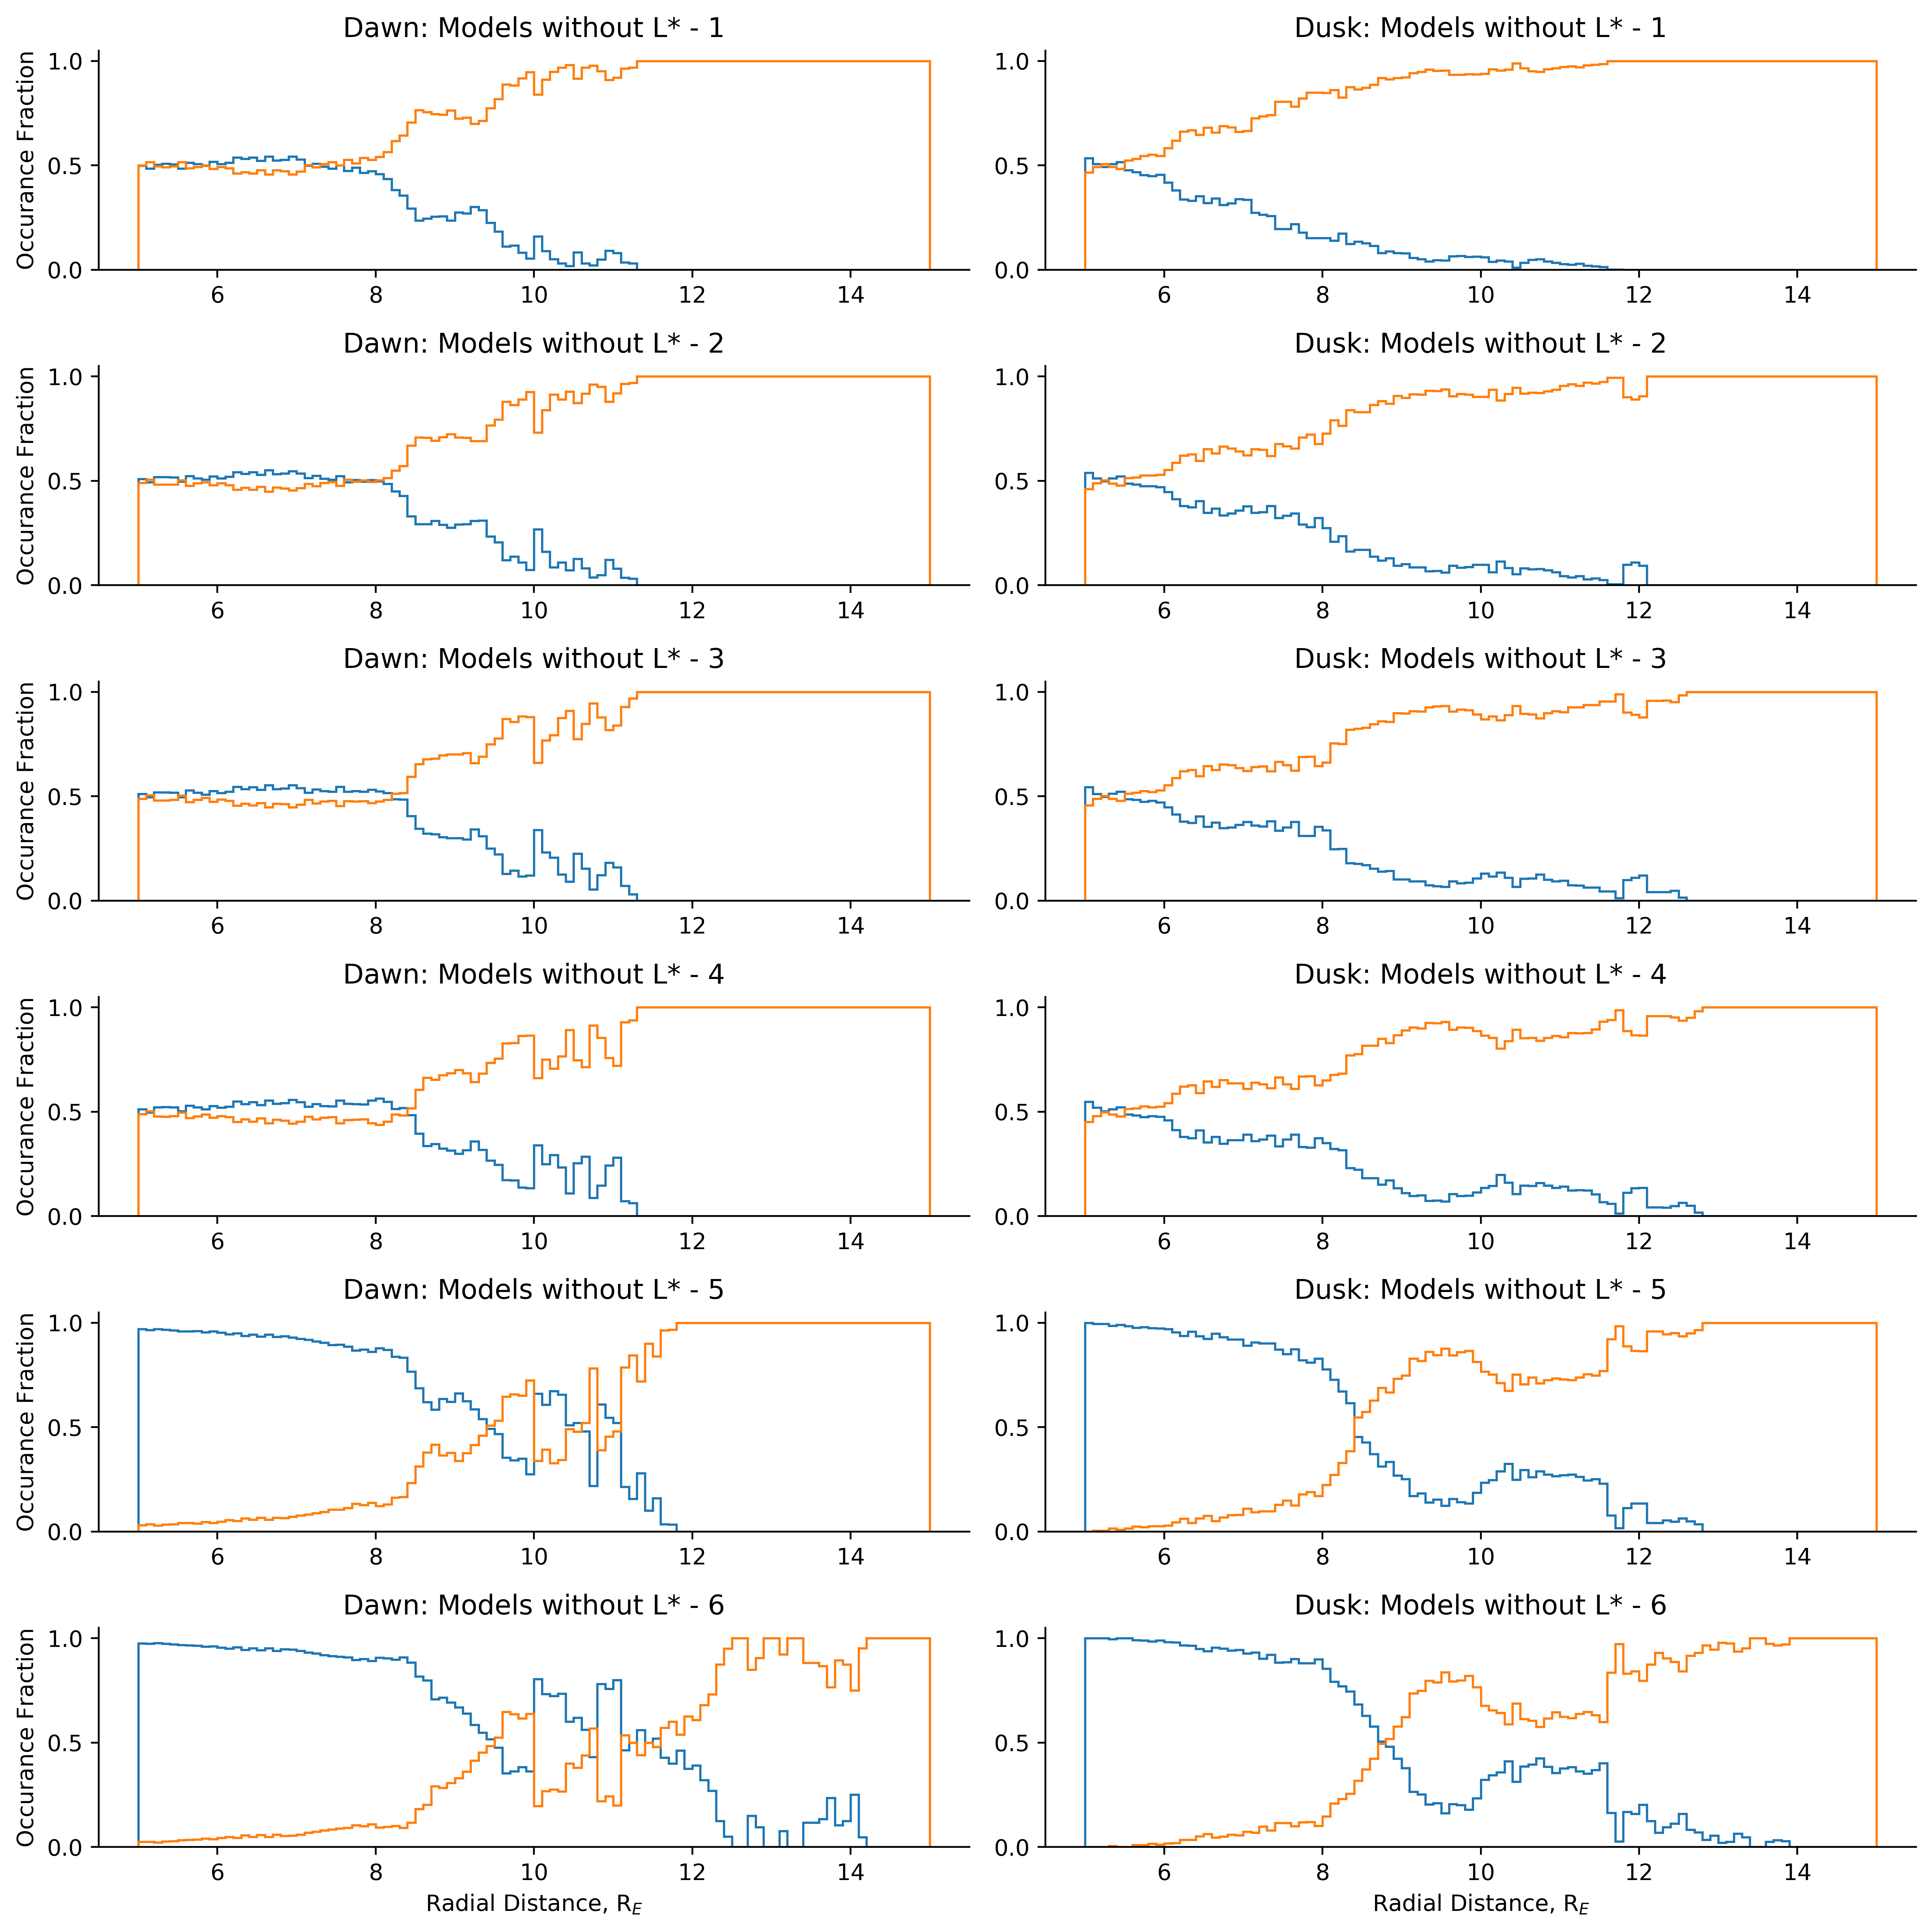

In [146]:
fig = plt.figure(figsize=(12,12),dpi=500)
axs = [plt.subplot(6,2,i+1) for i in range(12)]
for j in range(1,7):
    da_lcds['counts'] = da_lcds.isnull().sum(axis=1).tolist()
    da_lcds['in_out'] = [False if i >= j else True
                         for i in da_lcds.counts]
    du_lcds['counts'] = du_lcds.isnull().sum(axis=1).tolist()
    du_lcds['in_out'] = [False if i >= j else True
                         for i in du_lcds.counts]
    
    dawn_f3['in_ms'] = da_lcds['in_out']
    dusk_f3['in_ms'] = du_lcds['in_out']
    
    # Plotting distributions of the radial distance.
    n,bins = np.histogram(dawn_f3['pos_r_mag'],bins=100,range=(5,15))
    nin,binin = np.histogram(dawn_f3[dawn_f3.in_ms==True]['pos_r_mag'],bins=100,range=(5,15))
    nou,binou = np.histogram(dawn_f3[dawn_f3.in_ms==False]['pos_r_mag'],bins=100,range=(5,15))

    axs[(j-1)*2].hist(bins[:-1],bins,weights=nin/n,
             histtype='step',label='Inside')
    axs[(j-1)*2].hist(bins[:-1],bins,weights=nou/n,
             histtype='step',label='Outside')

    axs[(j-1)*2].set_title('Dawn: Models without L* - '+str(j))
       
    # Plotting distributions of the radial distance.
    n,bins = np.histogram(dusk_f3['pos_r_mag'],bins=100,range=(5,15))
    nin,binin = np.histogram(dusk_f3[dusk_f3.in_ms==True]['pos_r_mag'],bins=100,range=(5,15))
    nou,binou = np.histogram(dusk_f3[dusk_f3.in_ms==False]['pos_r_mag'],bins=100,range=(5,15))

    axs[2*j-1].hist(bins[:-1],bins,weights=nin/n,
             histtype='step',label='Inside')
    axs[2*j-1].hist(bins[:-1],bins,weights=nou/n,
             histtype='step',label='Outside')

    axs[2*j-1].set_title('Dusk: Models without L* - '+str(j))
       
ax1.legend(loc='upper left',frameon=False)
[i.set_ylabel('Occurance Fraction') for i in axs[::2]]
[i.set_xlabel('Radial Distance, R$_E$') for i in axs[10:]]

sbn.despine()
plt.tight_layout()

plt.show()